This notebook allows to build `DataPreparator` object from a dataset.

In [1]:
import jyquickhelper
jyquickhelper.add_notebook_menu(first_level=1, last_level=4, header="Dataset preparation with DatasetPreparator")

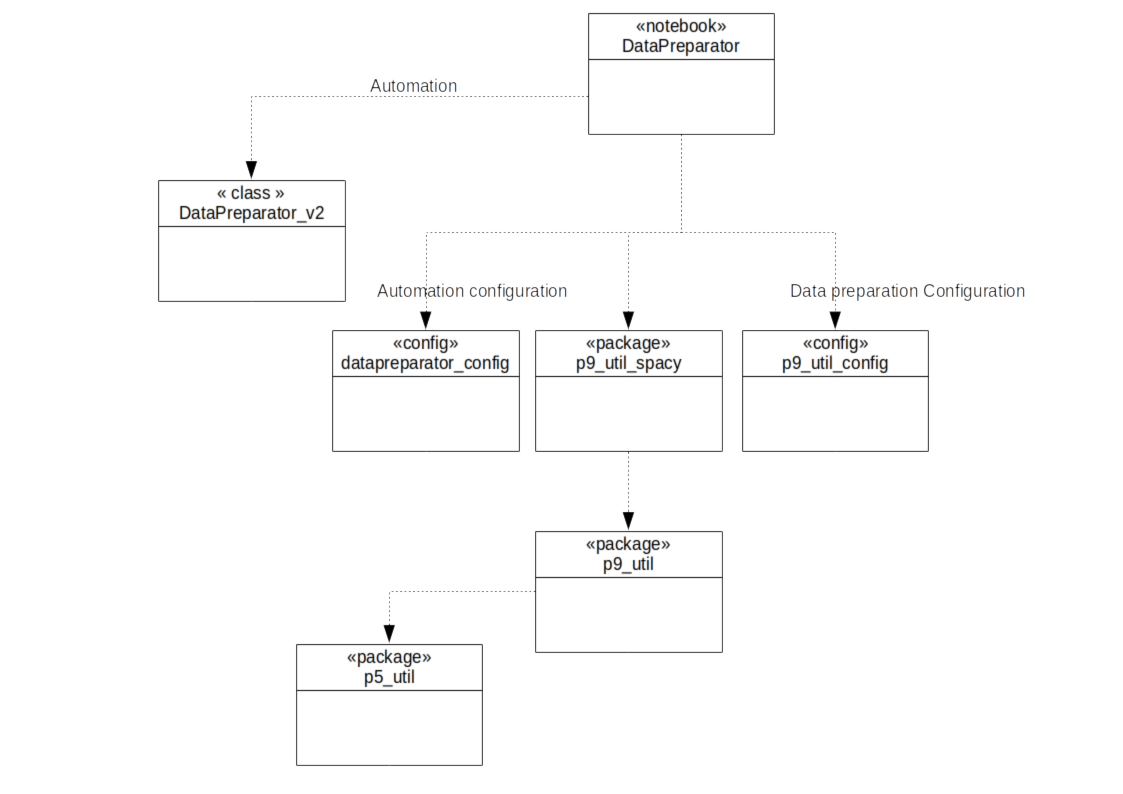

In [62]:
from IPython.display import Image
Image("img/SoftwareEngineeringDataPreparation.png")

# <font color=blus>0. Notebook configuration</font>

In [20]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#------------------------------------------------
# Data folder
# ../../datascience_kaggle_data_project/
# or
# /media/bangui/Diskeom/Kaggle/data
#------------------------------------------------


#  <font color=blus> 1. Data preparation with `DataPreparator_v2` </font>

## <font color=blus> 1.0. Load of data </font>


    Processing data is intended in splitting train dataset into new train and test dataset.
    This is done in order to train a model that we expect to generalize over provided test dataset.
    
    Provided test dataset is a file holding a collection of documents. Predictions, in term of probability 
    of toxicity, will be applied on this test dataset thanks to the estimator trained with train dataset.
    
 

In [103]:
import pandas as pd

#df_test = pd.read_csv('./data/test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
print(df_train.shape)
df_train['comment_text'] = df_train['comment_text'].astype(str)
df_train['comment_text'] = df_train['comment_text'].apply(lambda x : x.lower())
df_train.dropna(subset=['target'], how='all', inplace = True)
print(df_train.shape)

(1804874, 45)
(1804874, 45)


## <font color=blus> 1.1. Build of train and valid dataset </font>

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train['comment_text'],df_train['target'],test_size=0.33, random_state=42)

print("Train dataset: X = {} Label= {}".format(X_train.shape, y_train.shape))
print("Test dataset:  X = {} Label= {}".format(X_test.shape,  y_test.shape))

Train dataset: X = (1209265,) Label= (1209265,)
Test dataset:  X = (595609,) Label= (595609,)


In [5]:
import dill
import p5_util

filename = './data/X_y_train.dill'
p5_util.object_dump((X_train, y_train),filename)

In [6]:
import dill
import p5_util

filename = './data/X_y_valid.dill'
p5_util.object_dump((X_test, y_test),filename)

### <font color=blus> 1.1.1. Build balanced classes of train dataset </font>
    
    For binary classification, documents classified as toxic and those that are classified as 
    non toxic are strongly unbalanced (see dataset analysis notebook).
    This lead to an unbalanced result, due to the fact that one class contributes more then 
    other to cost function deacrease.
    As the result, model learn more from one class then the other, leading to an unbalanced result
    in terms of performances.
    
    Build of balanced classes aims to compensate this bias.
    

#### <font color=blus>Load train dataset</font>

In [1]:
import p5_util
filename = './data/X_y_train.dill'
X_train, y_train = p5_util.object_load(filename)

p5_util.object_load : fileName= ./data/X_y_train.dill


#### <font color=blus> Process to a binary split for target</font>

    Threshold for binary avlue is fixed

In [2]:
import p9_util_config
dict_param_preparator = p9_util_config.dict_param_preparator
dict_param_preparator['binary_threshold'] = 0.5

In [3]:
ser_0 = y_train[y_train.values <= dict_param_preparator['binary_threshold']]
ser_1 = y_train[y_train.values  > dict_param_preparator['binary_threshold']]

#### <font color=blus>Compute balanced value</font>

In [4]:
print(len(ser_0))
print(len(ser_1))

1138246
71019


In [7]:
dict_param_preparator['n_sample_per_class'] = min(len(ser_0), len(ser_1))

In [8]:
import p5_util
filename = './data/dict_param_preparator.dill'
p5_util.object_dump(dict_param_preparator,filename, is_verbose=True)

object_dump: file name= ./data/dict_param_preparator.dill


#### <font color=blus>Sampling a balanced binary splited target</font>

In [2]:
import p5_util
filename_dict_param_preparator = './data/dict_param_preparator.dill'
dict_param_preparator = p5_util.object_load(filename_dict_param_preparator, is_verbose=True)
dict_param_preparator

p5_util.object_load : fileName= ./data/dict_param_preparator.dill


{'binary_threshold': 0.5, 'n_sample_per_class': 71019}

In [10]:
import pandas as pd
import numpy as np
import p5_util
import p9_util

filename = './data/X_y_train.dill'

filename_valid_blanced = p9_util.X_y_balance_binary(filename, \
                                                    dict_param_preparator['n_sample_per_class'], \
                                                    dict_param_preparator['binary_threshold'])

/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.
W1021 15:57:12.196863 139785281996608 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1021 15:57:12.197720 139785281996608 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W1021 15:5

p5_util.object_load : fileName= ./data/X_y_train.dill
object_dump: file name= ./data/X_y_balanced_train.dill


#### <font color=blus>Balanced binary class for validation dataset</font>

In [14]:
import pandas as pd
import numpy as np
import p5_util
import p9_util

#--------------------------------------------------------------------------------------
# For validation dataset, class balancing do not mater.
# Threshold is fixed to 0. All items from validation dataset will be taken into account
#--------------------------------------------------------------------------------------
filename = './data/X_y_valid.dill'

filename_valid_balanced = p9_util.X_y_balance_binary(filename, \
                                                    dict_param_preparator['n_sample_per_class'], \
                                                    0.0)

p5_util.object_load : fileName= ./data/X_y_valid.dill
object_dump: file name= ./data/X_y_balanced_valid.dill


In [129]:
ser_X_valid, ser_y_valid = p5_util.object_load(filename_valid_balanced)
ser_X_valid.shape, ser_y_valid.shape

p5_util.object_load : fileName= ./data/X_y_balanced_valid.dill


((142038,), (142038,))

In [130]:
ser_X_valid.iloc[50]

"it's in the constitution?  i'm reading our state constitution now and i can't seem to find any mention or reference to this.  could you please tell me where in the constitution it says this?  thanks!"

# <font color=blus> 2. Manual data preparation </font>

## <font color=blus>2.1  Step 1 : data preparation</font>

    The whole process is driven with Spacy library.
    
    This step, data-preparation, includes folowing operations : 
        * Configuration of automated process. This configuration is enclosed 
          into file dict_param_preparator.dill
          This configuration file allows to address a data preparation pipeline.
        * Tokenization 
        * Tokens filtering depending of rules implemented into function p9_util_spacy.spacy_is_token_valid
        * Lemmatization


In [60]:
import pandas as pd
import p9_util

In [6]:
import p5_util
filename = './data/dict_param_preparator.dill'
dict_param_preparator = p5_util.object_load(filename, is_verbose=True)
dict_param_preparator

p5_util.object_load : fileName= ./data/dict_param_preparator.dill


{'binary_threshold': 0.5, 'n_sample_per_class': 71019, 'max_row': 100}

In [3]:
import datapreparator_config

dict_param_sequence = datapreparator_config.dict_param_sequence

#-----------------------------------------------------------------------------------
# For balanced binary class, total number of items from train dataset
# is 2 times the number of items per class
#-----------------------------------------------------------------------------------
dict_param_sequence['n_sample_train'] = dict_param_preparator['n_sample_per_class']*2
dict_param_sequence

{'step': 1,
 'step_end': 2,
 'previous_step_file_name': './data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__train_60000_step1.dill',
 'dict_param_step': {1: {'dataset_filename': './data/X_y_balanced',
   'dict_param_dataprep': {'other': None,
    'slice_length': 10000,
    'min_token_len': 2,
    'max_token_len': -1,
    'min_doc_len': 1,
    'max_doc_len': -1,
    'spacy_model_language': 'en_core_web_lg',
    'tokenizer': None,
    'max_padding_length': None,
    'oov_keyword': None,
    'entity_keyword': None,
    'nb_word_most_frequent': 0,
    'is_df_copied': False,
    'is_tfidf': False,
    'threshold': 0.0}},
  2: {'dataprep_step_filename': None,
   'dict_param_dataprep': {'other': None,
    'slice_length': 10000,
    'min_token_len': 2,
    'max_token_len': -1,
    'min_doc_len': 1,
    'max_doc_len': -1,
    'spacy_model_language': 'en_core_web_lg',
    'tokenizer': None,
    'max_padding_length': None,
    'oov_keyword': None,
    'entity_keyword': None,
    'nb_word_mo

In [4]:
dict_param_dataprep = dict_param_sequence['dict_param_step'][1]['dict_param_dataprep']
dict_param_dataprep

{'other': None,
 'slice_length': 10000,
 'min_token_len': 2,
 'max_token_len': -1,
 'min_doc_len': 1,
 'max_doc_len': -1,
 'spacy_model_language': 'en_core_web_lg',
 'tokenizer': None,
 'max_padding_length': None,
 'oov_keyword': None,
 'entity_keyword': None,
 'nb_word_most_frequent': 0,
 'is_df_copied': False,
 'is_tfidf': False,
 'threshold': 0.0}

In [5]:
import p5_util
import p9_util_spacy

min_token_len = dict_param_sequence['dict_param_step'][1]['dict_param_dataprep']['min_token_len']
max_token_len = dict_param_sequence['dict_param_step'][1]['dict_param_dataprep']['max_token_len']
filename = './data/X_y_balanced_train.dill'
X,y = p5_util.object_load(filename)
X = X.sample(dict_param_sequence['n_sample_train'])
y = y[X.index]

dict_param={
'oov_keyword'  : dict_param_dataprep['oov_keyword'],
'entity_keyword' :dict_param_dataprep['entity_keyword'],
'min_token_len': dict_param_dataprep['min_token_len'],
'max_token_len':dict_param_dataprep['max_token_len'],
}
df_dataprep = p9_util_spacy.spacy_dataprep(X,**dict_param)



#-----------------------------------------------------------------------
# Drop rows with empty tokens
#-----------------------------------------------------------------------
column_name = p9_util.COLUMN_NAME_COUNT
df_dataprep = df_dataprep[df_dataprep[column_name]>0].copy(deep=True)


p5_util.object_load : fileName= ./data/X_y_balanced_train.dill


In [6]:
import p5_util
filename = './data/df_dataprep_'+str(df_dataprep.shape[0])+'.dill'
p5_util.object_dump(df_dataprep,filename)

## <font color=blus>2.2 Step 2 : digitalization</font>

    This step allows to build a representation of tokenized documents.
    Glove embeddings from inside Spacy is used into this process.
    As a result, each document is represented as a matrix where : 
    * The number of row is the maximum number of tokens into a document
    * The number of olumns is the embeddings size.

### <font color=blus>2.2.1 Load of file issued from data-preparation</font>

In [4]:
import p5_util
filename = './data/df_dataprep_141651.dill'
df_dataprep = p5_util.object_load(filename)

p5_util.object_load : fileName= ./data/df_dataprep_141651.dill


In [36]:
df_dataprep.sample(5)

,docs,counting,tokens
550528,you're ridiculous.,1,[ridiculous]
315357,sore loser much?,2,"[sore, loser]"
687613,utter garbage.,2,"[utter, garbage]"
723130,"first they ask: siri, what to do? then run a p...",3,"[ask, run, poll]"
1079027,interesting to see the names of the elite who ...,23,"[interesting, name, elite, sure, story, secret..."


In [3]:
df_dataprep.shape

(141651, 3)

In [20]:
df_dataprep.iloc[0:10]

,docs,counting,tokens
1514511,i'm wondering if the interracial chick is lett...,23,"[wonder, interracial, chick, let, man, know, p..."
480772,har har har. celebiots. is that a combo of cel...,29,"[har, har, har, celebiot, combo, celebrity, id..."
360061,and this after walker has done everything he c...,64,"[walker, support, exxon, pressure, walker, dem..."
1590975,oh is that what you did when you dragged the e...,5,"[oh, drag, election, year, ago]"
866162,another liber government platitude stating the...,51,"[liber, government, platitude, state, obvious,..."
594044,"first, she was not ""cruelly persecuted by musl...",64,"[not, cruelly, persecute, muslim, arab, own, f..."
600828,i agree with nixing proportional representatio...,37,"[agree, nix, proportional, representation, sim..."
691779,we post off the wall sites? you have not sited...,47,"[post, wall, site, not, site, thing, say, drop..."
47434,"yes, this was a game i won't be replaying with...",23,"[yes, game, will, replay, dvr, blazer, win, pl..."
1463407,[to say one law can defeat another shows just ...,25,"[law, defeat, show, ignorant, person, tell, re..."


### <font color=blus>2.2.2 Step by step digitalization process</font>

    This process allows to save memory ressources.
    Dataframe issued from data-preparation is processed by bulk of rows.
    Each bulk is saved into a file.

In [5]:
bulk_row = 1000
nb_step = df_dataprep.shape[0]//bulk_row
remain_step = df_dataprep.shape[0]%1000
print("Bulk size= {} / Number of steps= {} / Ramining elements= {}/ Total number of rows={}".format(bulk_row, nb_step, remain_step, df_dataprep.shape[0]))

print("Is bulk process valid? : {}".format(df_dataprep.shape[0] == nb_step*bulk_row+remain_step))


Bulk size= 1000 / Number of steps= 141 / Ramining elements= 651/ Total number of rows=141651
Is bulk process valid? : True


    Figure below allows to select the maximum number of tokens per document (text, comment).

In [55]:
df_dataprep.columns

Index(['docs', 'counting', 'tokens'], dtype='object')

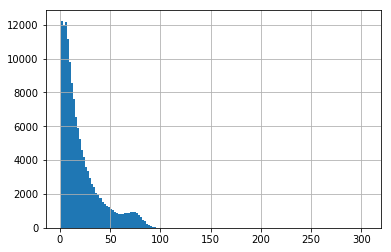

In [47]:
df_dataprep.counting.hist(bins=150)

In [48]:
df_dataprep.counting.describe()

count    141651.000000
mean         21.617772
std          19.714594
min           1.000000
25%           7.000000
50%          15.000000
75%          29.000000
max         304.000000
Name: counting, dtype: float64

    Once maximum number of tokens per document is fixed, step by step digitalization process start.

In [8]:
max_row = 100
bulk_id_start = 0

dict_param_preparator['max_row'] = max_row
dict_param_preparator['nb_step'] = nb_step
dict_param_preparator['bulk_row'] = bulk_row
dict_param_preparator['remain_step'] = remain_step
dict_param_preparator['embedding'] = 300

p5_util.object_dump(dict_param_preparator,filename_dict_param_preparator, is_verbose=True)

object_dump: file name= ./data/dict_param_preparator.dill


In [51]:
filename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedimport time
import p5_util
import p9_util_spacy

root_filename = './data/df_dataprep_matrix_'
start_time = time.time()
for bulk_id in range(bulk_id_start,nb_step) :
    item_start = bulk_id*bulk_row
    item_end = item_start+bulk_row
    filename = root_filename+str(bulk_id)+'.dill'
    if True :
        df_dataprep_matrix = p9_util_spacy.build_padded_matrix(df_dataprep.iloc[item_start:item_end], dict_token_coeff=None, max_row=max_row)
        p5_util.object_dump(df_dataprep_matrix, filename)
    elapsed_time = time.time() - start_time
    start_time = elapsed_time
    print("Range processed : {} --> {} Elapsed time : {:2f}".format(item_start,item_end, elapsed_time), end='\r')

if 0 < remain_step  :
    start_time = time.time()
    print("")
    bulk_id+=1
    item_start = item_end
    item_end = item_start+remain_step
    filename = root_filename+str(bulk_id)+'.dill'
    if True :
        df_dataprep_matrix = p9_util_spacy.build_padded_matrix(df_dataprep.iloc[item_start:item_end], dict_token_coeff=None, max_row=max_row)
        p5_util.object_dump(df_dataprep_matrix, filename)
    elapsed_time = time.time() - start_time
    start_time = elapsed_time
    print("Range processed : {} --> {} Elapsed time : {:2f}".format(item_start,item_end, elapsed_time), end='\r')



build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 0 --> 1000 Elapsed time : 114.706103
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 1000 --> 2000 Elapsed time : 1571752682.877326
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 2000 --> 3000 Elapsed time : 228.413722
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 3000 --> 4000 Elapsed time : 1571752806.448530
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 4000 --> 5000 Elapsed time : 348.116844
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 5000 --> 6000 Elapsed time

Range processed : 47000 --> 48000 Elapsed time : 1571755674.179123
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 48000 --> 49000 Elapsed time : 3245.696687
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 49000 --> 50000 Elapsed time : 1571755790.960252
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 50000 --> 51000 Elapsed time : 3365.982282
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 51000 --> 52000 Elapsed time : 1571755936.662069
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 52000 --> 53000 Elapsed time : 3497.752695
build_padded_matrix : build of matrix for each text...

build_padded_ma


build_padded_matrix : Padd / truncate matrix rows...
Range processed : 95000 --> 96000 Elapsed time : 1571758597.473797
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 96000 --> 97000 Elapsed time : 6118.978447
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 97000 --> 98000 Elapsed time : 1571758703.178539
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 98000 --> 99000 Elapsed time : 6277.235119
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 99000 --> 100000 Elapsed time : 1571758845.512002
build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
Range processed : 100000 --> 101000 Elapsed time : 6390.818628
build_padded_m

# <font color=blus> 3. Automated data preparation with `DataPreparator_v2`</font>

## <font color=blus> 3.1. Automated process configuration</font>

In [25]:
import datapreparator_config
help(datapreparator_config)

Help on module datapreparator_config:

NAME
    datapreparator_config - This configuration allows to run an automated data-preparation process.

DESCRIPTION
    This process is a sequence of 3 steps : 
    
        Step 1 : core data preparation using Spacy. 
        Core data preparation includes  :
            *   lematization, 
            *   stop words, 
            *   filtering out of vocubulary words with dictionary, 
            *   unknown words substitution, 
            *   entity recognition,
            *   cleaning, 
            *   tokenization.
            *   vectorization.
        At the end of this step, each text from dataset is digitalized as a vector.
        Input : 
            --> ./data/X_y_<data_type>.dill file
        Output :
            --> ./data/DataPreparator_v2_40Tokens_spacy_<data_type>_<sample>_step1.dill
            
            where sample is the number of texts sampled from train dataset.
            
        Step 2 : this a digitalization step.

## <font color=blus> 3.2 Automated process application </font>

In [10]:
dict_param_dataprep

{'other': None,
 'slice_length': 10000,
 'min_token_len': 2,
 'max_token_len': -1,
 'min_doc_len': 1,
 'max_doc_len': -1,
 'spacy_model_language': 'en_core_web_lg',
 'tokenizer': None,
 'max_padding_length': None,
 'oov_keyword': None,
 'entity_keyword': None,
 'nb_word_most_frequent': 0,
 'is_df_copied': False,
 'is_tfidf': False,
 'threshold': 0.0}

In [5]:
import test_datapreparator
import datapreparator_config


filename = test_datapreparator.dataprepatator_sequence_process(dict_param_sequence,is_debug=False)

p5_util.object_load : fileName= ./data/X_y_balanced_train.dill
fit : list_word_most_frequent length= 0

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer()


*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issue


*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issue


*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issue


*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issued from spacy tokenizer= 0    []
Name: tokens, dtype: object

*** ERROR : p9_util_spacy.spacy_tokenizer() : list index out of range
p9_util_spacy.spacy_tokenizer() : df_data[p9_util_spacy.COLUMN_NAME_TOKEN].tolist()= []
p9_util_spacy.spacy_tokenizer() : tokens issue

KeyError: 'misunderstanding'

## <font color=blus> 3.3 Step 3 automated process application </font>

In [ ]:
import test_datapreparator
import datapreparator_config


filename = test_datapreparator.dataprepatator_sequence_process(dict_param_sequence,is_debug=False)

### <font color=blus> 3.3.1 Save data preprator configuration </font>

    Such configuration will be used when building estimators.
    The max_length parameter into configuration parameters is updated.
    This parameter is used in order to padd digitalized dataset.
    This allows validation data-preparation to take place with same max_length parameter.

In [3]:
import p5_util
import test_datapreparator

#-----------------------------------------------------------------------------
# Update padding length into parameter configuration with value from train 
# data-preparator
# Validtion data preparation process will use such value
#-----------------------------------------------------------------------------
step=1
#filename = './data/dict_param_sequence_train_60000.dump'
#dict_param_sequence = p5_util.object_load(filename)

filename = './data/DataPreparator_v2_MaxTokens_spacy__en_core_web_lg__train_60000_step2.dill'
dataprep = p5_util.object_load(filename)

if dict_param_sequence['dict_param_step'][step]['dict_param_dataprep']['max_padding_length'] is None :
    dict_param_sequence['dict_param_step'][step]['dict_param_dataprep']['max_padding_length'] = dataprep.max_length
else :
    pass

data_type = dict_param_sequence['data_type']
n_sample = test_datapreparator.get_n_sample(dict_param_sequence)

filename = './data/dict_param_sequence_'+str(data_type)+'_'+str(n_sample)+'.dump'
print(filename)

p5_util.object_dump(dict_param_sequence,filename)

./data/dict_param_sequence_train_60000.dump


## <font color=blus> 3.4 Validation dataset : automated process application </font>
    
    All data preparation is applied to validation dataset.
    Configuration file used for train dataset data preparation is updatated 
    with parameters for validation dataset.
    

### <font color=blus> 3.4.1 Validation dataset : steps 1 & 2 </font>

In [57]:
filename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedfilename_valid_blancedimport p5_util
import test_datapreparator

# Configuration file used for train dataset is reloaded.
dict_param_sequence = p5_util.object_load('./data/dict_param_sequence_train_60000.dump')

dict_param_sequence['data_type'] = 'valid'
dict_param_sequence['step'] = 1

dict_param_sequence

p5_util.object_load : fileName= ./data/dict_param_sequence_train_60000.dump


{'step': 1,
 'step_end': 2,
 'previous_step_file_name': './data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__train_60000_step1.dill',
 'dict_param_step': {1: {'dataset_filename': './data/X_y_balanced',
   'dict_param_dataprep': {'other': None,
    'slice_length': 10000,
    'min_token_len': 2,
    'max_token_len': -1,
    'min_doc_len': 1,
    'max_doc_len': -1,
    'spacy_model_language': 'en_core_web_lg',
    'tokenizer': None,
    'max_padding_length': 105,
    'oov_keyword': None,
    'entity_keyword': None,
    'nb_word_most_frequent': 0,
    'is_df_copied': False,
    'is_tfidf': False}},
  2: {'dataprep_step_filename': None,
   'dict_param_dataprep': {'other': None,
    'slice_length': 10000,
    'min_token_len': 2,
    'max_token_len': -1,
    'min_doc_len': 1,
    'max_doc_len': -1,
    'spacy_model_language': 'en_core_web_lg',
    'tokenizer': None,
    'max_padding_length': 105,
    'oov_keyword': None,
    'entity_keyword': None,
    'nb_word_most_frequent': 0,
    'is

In [3]:
import test_datapreparator
import datapreparator_config


filename = test_datapreparator.dataprepatator_sequence_process(dict_param_sequence,is_debug=False)

p5_util.object_load : fileName= ./data/X_y_balanced_valid.dill
fit : list_word_most_frequent length= 0

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

***WARNING : empy list of tokens

Step : 1 Save data-preparation into file ./data/DataPreparator_v2_MaxTokens_spacy__en_core_web_lg__valid_10000_step1.dill

Step : 2
p5_util.object_load : fileName= ./data/DataPreparator_v2_MaxTokens_spacy__en_core_we

/home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p9_util_spacy.py:684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_data['matrix'] = ser_matrix



build_padded_matrix : Padd / truncate matrix rows...


/home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p9_util_spacy.py:702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_data['matrix_padded'] = ser_matrix_padded


object_dump: file name= ./data/df_data_df_valid_10000_step2_0.dill

build_padded_matrix : build of matrix for each text...

build_padded_matrix : Padd / truncate matrix rows...
object_dump: file name= ./data/df_data_df_valid_10000_step2_1.dill

Step 2 : Save data-preparation into file ./data/DataPreparator_v2_MaxTokens_spacy__en_core_web_lg__valid_10000_step2.dill ...

Step 2 : Save data-preparation into file ./data/DataPreparator_v2_MaxTokens_spacy__en_core_web_lg__valid_10000_step2.dill Done!

Step 2 : Step by step data-preparation : Restart process with (step, substep, previous file) = (2,1,./data/DataPreparator_v2_MaxTokens_spacy__en_core_web_lg__valid_10000_step2.dill) in configuration file!


### <font color=blus> 3.4.2 Validation dataset : step 3 process </font>

    This step is dedicated to reduction of dataset dimension with a PCA operator.
    
    For validation dataset, PCA operator is the one built for train dataset.
    
    DataPreparator_v2 for validation dataset is loaded and its PCA operator is used for 
    step-3 validation dataset.

In [68]:
import datapreparator_config
dict_param_sequence = datapreparator_config.dict_param_sequence

dict_param_sequence

{'step': 2,
 'step_end': 2,
 'previous_step_file_name': './data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__train_60000_step3_substep1.dill',
 'dict_param_step': {1: {'dataset_filename': './data/X_y_balanced',
   'dict_param_dataprep': {'other': None,
    'slice_length': 10000,
    'min_token_len': 2,
    'max_token_len': 15,
    'min_doc_len': 5,
    'max_doc_len': 500,
    'spacy_model_language': 'en_core_web_lg',
    'tokenizer': None,
    'max_padding_length': 40,
    'oov_keyword': 'unknown',
    'entity_keyword': None,
    'nb_word_most_frequent': 100,
    'is_df_copied': False,
    'is_tfidf': False}},
  2: {'dataprep_step_filename': './data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_10000_step1.dill',
   'dict_param_dataprep': {'other': None,
    'slice_length': 10000,
    'min_token_len': 2,
    'max_token_len': 15,
    'min_doc_len': 5,
    'max_doc_len': 500,
    'spacy_model_language': 'en_core_web_lg',
    'tokenizer': None,
    'max_padding_length': 40,

In [69]:
import p5_util
import test_datapreparator
import datapreparator_config

data_type = dict_param_sequence['data_type']
is_debug = False
if 'valid' == data_type :
    step = dict_param_sequence['step']
    step_end = dict_param_sequence['step_end']

    if 2 == step_end :
        #----------------------------------------------------------
        # Get filename from last sequence step.
        # get it before step increase and update configuration parameter.
        #----------------------------------------------------------
        previous_step_file_name = \
        test_datapreparator.datapreparator_filename(data_type, dict_param_sequence, \
                                                                              step=step_end)

        #----------------------------------------------------------
        # Proceed to next step process
        #----------------------------------------------------------
        step = step_end+1
        step_end += 1
        dict_param_sequence['step'] = step
        dict_param_sequence['step_end'] = step_end
        print("\nStep : {} / Dataset type = {}".format(step, data_type))
        if not is_debug :
            #--------------------------------------------------------------------------------------
            # Get DataPrepartor object issued from train dataset
            #--------------------------------------------------------------------------------------
            tmp_data_type = 'train'
            dict_param_sequence_train = dict_param_sequence.copy()
            dict_param_sequence_train['data_type'] = tmp_data_type

            #--------------------------------------------------------------------------------------
            # Change datatype in order to get file name from which train dataset has been processed
            #--------------------------------------------------------------------------------------
            filename_train_datapreparator = \
            test_datapreparator.datapreparator_filename(tmp_data_type, dict_param_sequence_train, step=None)
            datapreparator_train = p5_util.object_load(filename_train_datapreparator)
        
        #-------------------------------------------------------------------------------
        # Update of sequence configuration parameters with PCA operator and  
        # file name from previous step.
        #-------------------------------------------------------------------------------

        if not is_debug :
            dict_param_sequence['dict_param_step'][step]['xpca'] = datapreparator_train.xpca
        dict_param_sequence['previous_step_file_name'] = previous_step_file_name
        print(len(dict_param_sequence['dict_param_step']))
        filename = test_datapreparator.dataprepatator_sequence_process(dict_param_sequence,\
                                                               is_debug=is_debug)
        
    else :
        print("\n*** ERROR : Expected step= {} for validation dataset preparation / found step =3".format(2))
else :
    print("\n*** ERROR : Expected data-type= {} for validation step-3 application".format("valid"))






Step : 3 / Dataset type = valid
p5_util.object_load : fileName= ./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__train_60000.dill
3

Step : 3
p5_util.object_load : fileName= ./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_10000_step2.dill

Matrix dimension truncation...
p5_util.object_load : fileName= ./data/df_data_df_valid_10000_step2_0.dill
Processed file = ./data/df_data_df_valid_10000_step2_0.dill

p5_util.object_load : fileName= ./data/df_data_df_valid_10000_step2_1.dill
Processed file = ./data/df_data_df_valid_10000_step2_1.dill


Step 3 : Save data-preparation into file ./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_10000.dill ...

Step 3 : Save data-preparation into file ./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_10000.dill Done!


In [63]:
import p5_util
dataprep = p5_util.object_load('./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_10000.dill')

p5_util.object_load : fileName= ./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_10000.dill


### <font color=blus> 3.4.3 Display explained variance </font>

    Display explained variance from PCA operator issued from process.

In [38]:
import p5_util
data_type = 'train'
filename = test_datapreparator.datapreparator_filename(data_type, dict_param_sequence, step=None)
print(filename)
dataPreparator_v2 = p5_util.object_load(filename)

./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__train_10000.dill
p5_util.object_load : fileName= ./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__train_10000.dill



Number of dimensions for variance= 0.9 : 166


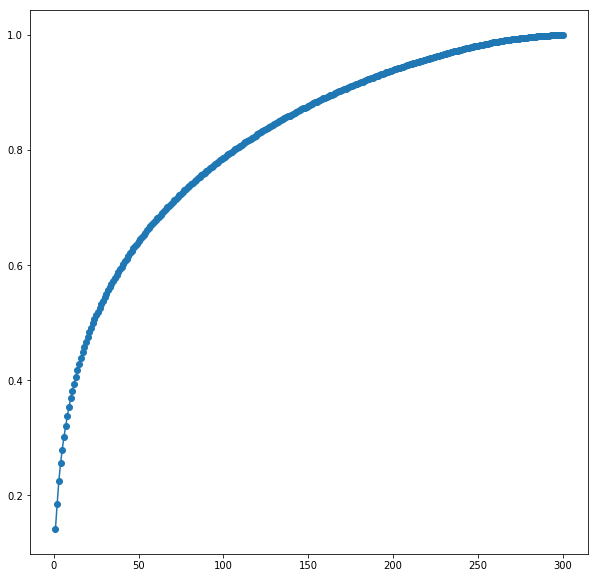

In [41]:
import p3_util_plot
p3_util_plot.plot_pca_variance(dataPreparator_v2.xpca)

step = 3
dict_param_sequence = datapreparator_config.dict_param_sequence
dict_param_step = dict_param_sequence['dict_param_step']
dict_step = dict_param_step[step]
percent_var=dict_step['percent_var']


dimensions = p3_util_plot.get_component_from_cum_variance(dataPreparator_v2.xpca, percent_var)
print("\nNumber of dimensions for variance= {} : {}".format(percent_var, dimensions))


In [12]:
import p5_util
data_type = 'valid'
filename = test_datapreparator.datapreparator_filename(data_type, dict_param_sequence, step=None)
print(filename)
dataPreparator_v2 = p5_util.object_load(filename)

./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_5000.dill
p5_util.object_load : fileName= ./data/DataPreparator_v2_40Tokens_spacy__en_core_web_lg__valid_5000.dill



Number of dimensions for variance= 0.9 : 166


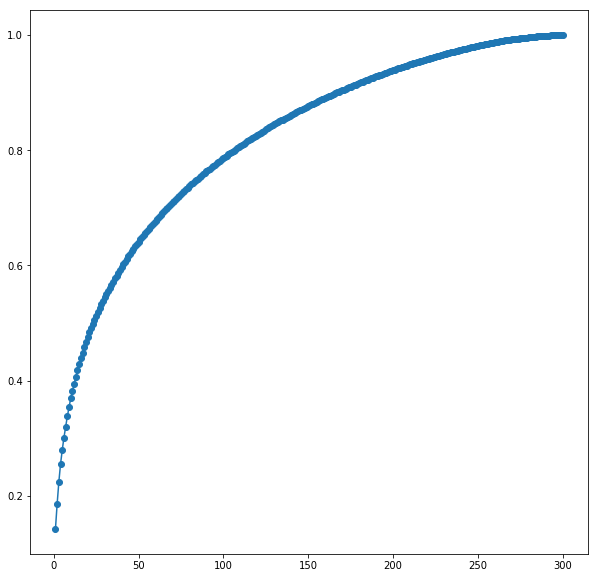

In [13]:
import p3_util_plot
p3_util_plot.plot_pca_variance(dataPreparator_v2.xpca)


step = 3
dict_param_sequence = datapreparator_config.dict_param_sequence
dict_param_step = dict_param_sequence['dict_param_step']
dict_step = dict_param_step[step]
percent_var=dict_step['percent_var']

dimensions = p3_util_plot.get_component_from_cum_variance(dataPreparator_v2.xpca, percent_var)
print("\nNumber of dimensions for variance= {} : {}".format(percent_var, dimensions))


    Display the number of dimensions for expected variance

In [42]:
import p3_util_plot
import datapreparator_config

step = 3
dict_param_sequence = datapreparator_config.dict_param_sequence
dict_param_step = dict_param_sequence['dict_param_step']
dict_step = dict_param_step[step]
percent_var=dict_step['percent_var']

dimensions = p3_util_plot.get_component_from_cum_variance(dataPreparator_v2.xpca, percent_var)
print("\nNumber of dimensions for variance= {} : {}".format(percent_var, dimensions))


Number of dimensions for variance= 0.9 : 166
